In [1]:
%matplotlib inline
from validphys.api import API
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate as scint
from collections import defaultdict, namedtuple
import operator
from pathlib import Path

from validphys.convolution import central_fk_predictions

In [2]:
fitname = "241002-ach-04-ht-tcm"
thcovmat_dict = API.fit(fit=fitname).as_input()["theorycovmatconfig"]

In [3]:
save_dir = f"./Results/{fitname}"
target_dir = Path(save_dir)
pickle_path = Path(save_dir + "/posteriors.pkl")
if not target_dir.is_dir():
  target_dir.mkdir(parents=True, exist_ok=True)

In [4]:
H2_coeff_list = thcovmat_dict["H2_list"]
HL_coeff_list = thcovmat_dict["HL_list"]


# dict used to produce theory predictions to construct the theory covmat as well as to produce
# theory predictions from the fit performed using the ht covmat (i.e. the predicitons that should
# be compared to data)
common_dict = dict(
    dataset_inputs={"from_": "fit"},
    fit=fitname,
    fits=[fitname],
    use_cuts="fromfit",
    metadata_group="nnpdf31_process",
    theory={"from_": "fit"},
    theoryid={"from_": "theory"},
)

In [5]:
# collect the information (predictions + kinematics) needed for the computation of the HT covmat

# Calculate theory predictions of the input PDF
S_dict = dict(
    theorycovmatconfig={"from_": "fit"},
    pdf={"from_": "theorycovmatconfig"},
    use_t0=True,
    datacuts={"from_": "fit"},
    t0pdfset={"from_": "datacuts"},
)
preds_ht_cov_construction = API.group_result_central_table_no_table(**(S_dict | common_dict))

LHAPDF 6.5.4 loading /opt/homebrew/Caskroom/miniconda/base/envs/nnpdf_doc/share/LHAPDF/210619-n3fit-001/210619-n3fit-001_0000.dat
210619-n3fit-001 PDF set, member #0, version 1


In [6]:
kinematics_all = API.group_kin_table_no_table(pdf={"from_": "fit"}, **common_dict)
preds_ht = pd.DataFrame(preds_ht_cov_construction['theory_central'])

In [7]:
# Join kinematics and preds_ht
try:
  pd.testing.assert_index_equal(kinematics_all.index, preds_ht.index)
except AssertionError as e:
  print("Different index")
  print(e)
else:
  preds_ht = pd.concat([preds_ht, kinematics_all], axis=1)

In [8]:
# Calculate theory predictions of the fit with ht covmat - this will be compared to data
preds = API.group_result_table_no_table(pdf={"from_": "fit"}, **common_dict)

LHAPDF 6.5.4 loading all 501 PDFs in set 241002-ach-04-ht-tcm
241002-ach-04-ht-tcm, version 1; 501 PDF members


# Construct HT covmat

In [9]:
pd.options.mode.chained_assignment = None

PDF_thcovmat = API.pdf(**(S_dict | common_dict))

# ABMP parametrisationa
x_abmp = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
x_nodes = thcovmat_dict.get('ht_knots', x_abmp)

included_proc = ["DIS NC"]
excluded_exp = {"DIS NC" : []}

# Initialise dataframe
for i in range(len(x_nodes)):
    preds_ht[f"p({i+1}+,0)"] = 0
    preds_ht[f"p(0,{i+1}+)"] = 0
    preds_ht[f"d({i+1}+,0)"] = 0
    preds_ht[f"d(0,{i+1}+)"] = 0

In [10]:
groups_index = API.groups_index(pdf={"from_": "fit"}, **common_dict)

In [11]:
proc_types = []
tmp =''
for name in preds_ht.xs('DIS NC', level='group')['process_type']:
  if name not in proc_types:
    proc_types.append(name)

In [12]:
def compute_ht_parametrisation(
        index: int,
        nodes: list,
        x: list,
        Q2: list,
        h_prior: list,
        reverse: bool = False
):
    if not reverse:
        shifted_H_list = [0 for k in range(len(nodes))]
        shifted_H_list[index] = h_prior[index]
    else:
        shifted_H_list = h_prior.copy()
        shifted_H_list[index] = 0

    H = scint.CubicSpline(nodes, shifted_H_list)
    H = np.vectorize(H)

    PC = H(x) / Q2
    return PC

In [13]:
groups_data = API.groups_data(pdf={"from_": "fit"}, **common_dict)
PDF_thcovmat = API.pdf(**(S_dict | common_dict))

In [33]:
for process_index, (process_name, process_group) in enumerate(preds_ht.groupby(level='group', sort=False)):
    for exp_index, (exp_name, exp_group) in enumerate(process_group.groupby(level='dataset', sort=False)):
        if process_name in included_proc and exp_name not in excluded_exp[process_name]:
          x = exp_group.kin_1.to_numpy()
          q2 = exp_group.kin_2.to_numpy()
          y = exp_group.kin_3.to_numpy()
          process_type = exp_group.process_type.iloc[0]
          
          for i in range(len(x_nodes)): 
            if process_type == "DIS_F2R":
                cuts = groups_data[process_index].datasets[exp_index].cuts
                fkspec_F2D, fkspec_F2P = groups_data[process_index].datasets[exp_index].fkspecs
                fk_F2D = fkspec_F2D.load_with_cuts(cuts)
                fk_F2P = fkspec_F2P.load_with_cuts(cuts)
                F2D = central_fk_predictions(fk_F2D, PDF_thcovmat)
                F2P = central_fk_predictions(fk_F2P, PDF_thcovmat)

                F2D = np.concatenate(F2D.values)
                F2P = np.concatenate(F2P.values)
                F2_ratio = operator.truediv(F2D, F2P)
                PC = compute_ht_parametrisation(i, x_nodes, x, q2, H2_coeff_list)

                preds_ht.loc[(process_name,exp_name), f"p({i+1}+,0)"] = operator.truediv(F2D, np.sum([F2P, PC],axis=0)) - F2_ratio
                preds_ht.loc[(process_name,exp_name), f"d({i+1}+,0)"] = operator.truediv(F2D, np.sum([F2D, PC],axis=0)) - F2_ratio
            
            elif process_type == "DIS_F2P":
               PC_2_p = compute_ht_parametrisation(i, x_nodes, x, q2, H2_coeff_list)
               preds_ht.loc[(process_name,exp_name), f"p({i+1}+,0)"] = PC_2_p
               

            elif process_type == "DIS_F2D":
               PC_2_d = compute_ht_parametrisation(i, x_nodes, x, q2, H2_coeff_list)
               preds_ht.loc[(process_name,exp_name), f"d({i+1}+,0)"] = PC_2_d

            elif process_type == "DIS_NCE" or "DIS_NCP":
                yp = 1 + np.power(1 - y, 2)
                yL = np.power(y, 2)
                N_L = - yL / yp
                PC_2_p = compute_ht_parametrisation(i, x_nodes, x, q2, H2_coeff_list)
                PC_L_p = compute_ht_parametrisation(i, x_nodes, x, q2, HL_coeff_list)
                preds_ht.loc[(process_name,exp_name), f"p({i+1}+,0)"] = PC_2_p
                preds_ht.loc[(process_name,exp_name), f"p(0,{i+1}+)"] = N_L * PC_L_p
                
            else:
               raise Exception(f"The process type `{exp_group.process_type}` has not been implemented.")

/var/folders/l5/l1kl3n_11gx3zm7b0wxctqym0000gn/T/ipykernel_6062/3805553743.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.
  preds_ht.loc[(process_name,exp_name), f"p({i+1}+,0)"] = operator.truediv(F2D, np.sum([F2P, PC],axis=0)) - F2_ratio
/var/folders/l5/l1kl3n_11gx3zm7b0wxctqym0000gn/T/ipykernel_6062/3805553743.py:24: PerformanceWarning: indexing past lexsort depth may impact performance.
  preds_ht.loc[(process_name,exp_name), f"d({i+1}+,0)"] = operator.truediv(F2D, np.sum([F2D, PC],axis=0)) - F2_ratio
/var/folders/l5/l1kl3n_11gx3zm7b0wxctqym0000gn/T/ipykernel_6062/3805553743.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.
  preds_ht.loc[(process_name,exp_name), f"p({i+1}+,0)"] = operator.truediv(F2D, np.sum([F2P, PC],axis=0)) - F2_ratio
/var/folders/l5/l1kl3n_11gx3zm7b0wxctqym0000gn/T/ipykernel_6062/3805553743.py:24: PerformanceWarning: indexing past lexsort depth may impact performance.
  preds_ht.loc[(process_name,exp_

In [15]:
S = np.zeros((preds_ht.shape[0], preds_ht.shape[0]))
for shift in preds_ht.columns[5:]:
    S += np.outer(preds_ht[shift].to_numpy(), preds_ht[shift].to_numpy())

S = pd.DataFrame(S, index=preds_ht.index, columns=preds_ht.index)

# Experimental covariance matrix
C = API.groups_covmat_no_table(**common_dict)

# Ensure that S anc C are ordered in the same way (in practice they already are)
S = S.reindex(C.index).T.reindex(C.index)

# Check reconstructed matrix

In [16]:
# check if the stored covmat is equal to S we recomputed above
fitpath = API.fit(fit=fitname).path
try:
    stored_covmat = pd.read_csv(
        fitpath / "tables/datacuts_theory_theorycovmatconfig_user_covmat.csv",
        sep="\t",
        encoding="utf-8",
        index_col=2,
        header=3,
        skip_blank_lines=False,
    )
except FileNotFoundError:
    stored_covmat = pd.read_csv(
        fitpath / "tables/datacuts_theory_theorycovmatconfig_theory_covmat_custom.csv",
        index_col=[0, 1, 2],
        header=[0, 1, 2],
        sep="\t|,",
        engine="python",
    ).fillna(0)
    storedcovmat_index = pd.MultiIndex.from_tuples(
        [(aa, bb, np.int64(cc)) for aa, bb, cc in stored_covmat.index],
        names=["group", "dataset", "id"],
    )
    stored_covmat = pd.DataFrame(
        stored_covmat.values, index=storedcovmat_index, columns=storedcovmat_index
    )
    stored_covmat = stored_covmat.reindex(S.index).T.reindex(S.index)


try:
  assert(np.allclose(S, stored_covmat))
except AssertionError:
    print("The two matrices are not the same. Comparing them exp by exp...")
    '''for set in S.xs('DIS NC', level='group').T.xs('DIS NC', level='group').groupby(level='dataset', sort=False):
      print(set[0])
   
    key1 = 'NMC_NC_NOTFIXED_P_EM-SIGMARED'
    key2 = 'NMC_NC_NOTFIXED_P_EM-SIGMARED'
    level = 'dataset'

    try:
      pd.testing.assert_frame_equal(
        S.xs(key1,level=level).T.xs(key2,level=level),
        stored_covmat.xs(key1,level=level).T.xs(key2,level=level)
      )
    except AssertionError as e:
      print(e)'''

# Theory Covariance Method

In [17]:
# Load the central value of the pseudodata
# this is needed to compute the distance between prediction and data
pseudodata = API.read_pdf_pseudodata(**common_dict)
dat_central = np.mean(
    [i.pseudodata.reindex(preds.index.to_list()).to_numpy().flatten() for i in pseudodata],
    axis=0,
)

In [18]:
# Compute delta_T_tilde (Eq. 3.37) and P_tilde (Eq. 3.38) of arXiv:2105.05114

# The factors 1/sqrt(2) are to normalize for the fact that beta provides information about
# theoretical uncertainties along two directions
# CHECK THIS PART
# b_tilde SHOULD BE INDEPENDENT OF THE PRIOR THAT WE USE TO MODEL HT CORRECTIONS.
central_ht_coeffs = np.zeros(2*len(H2_coeff_list) + 2*len(HL_coeff_list)) 

# Construct beta tilde
H_single_list = np.concatenate((H2_coeff_list, HL_coeff_list, H2_coeff_list, HL_coeff_list))
beta_tilde = []
for i, par in enumerate(H_single_list):
  aux = np.zeros(H_single_list.size)
  aux[i] = par
  beta_tilde.append(aux)

S_tilde = np.zeros((len(beta_tilde[0]), len(beta_tilde[0])))
for tilde in beta_tilde:
    S_tilde += np.outer(tilde,tilde)

In [114]:
ht_index_array = [
  np.concatenate([["H2p" for _ in range(len(x_nodes))],
                  ["H2d" for _ in range(len(x_nodes))],
                  ["HLp" for _ in range(len(x_nodes))],
                  ["HLd" for _ in range(len(x_nodes))]]),
  np.concatenate([[f"h2p_{i+1}" for i in range(len(x_nodes))],
                  [f"h2d_{i+1}" for i in range(len(x_nodes))],
                  [f"hLp_{i+1}" for i in range(len(x_nodes))],
                  [f"hLd_{i+1}" for i in range(len(x_nodes))]]),
]
ht_index_tuple = list(zip(*ht_index_array))
ht_index = pd.MultiIndex.from_tuples(ht_index_tuple, names=["HT", "coefficients"])

In [115]:
beta_tilde_df = pd.DataFrame(beta_tilde, 
                             columns=np.concatenate([
                              [f"p({i+1}+,0)" for i in range(len(x_nodes))],
                              [f"d({i+1}+,0)" for i in range(len(x_nodes))],
                              [f"p(0,{i+1}+)" for i in range(len(x_nodes))],
                              [f"d(0,{i+1}+)" for i in range(len(x_nodes))]]),
                              index = ht_index
                            )

In [116]:
S_hat = np.zeros((beta_tilde_df.shape[0], preds_ht.shape[0]))
for shift in beta_tilde_df.columns:
    S_hat += np.outer(beta_tilde_df[shift].to_numpy(), preds_ht[shift].to_numpy())

S_hat = pd.DataFrame(S_hat, index = ht_index)

In [117]:
# compute the matrix X encoding the PDF uncertainties of the predictions
preds_onlyreplicas = preds.iloc[:, 2:].to_numpy()
mean_prediction = np.mean(preds_onlyreplicas, axis=1)

X = np.zeros((preds.shape[0], preds.shape[0]))
for i in range(preds_onlyreplicas.shape[1]):
    X += np.outer(
        (preds_onlyreplicas[:, i] - mean_prediction), (preds_onlyreplicas[:, i] - mean_prediction)
    )
X *= 1 / preds_onlyreplicas.shape[1]

In [118]:
invcov = np.linalg.inv(C + S)

delta_T_tilde = - S_hat @ invcov @ (mean_prediction - dat_central)
# where are the X_tilde and X_hat terms in P_tilde?
# Maybe not present because we don't have correlations between theory parameters
P_tilde = S_hat @ invcov @ X @ invcov @ S_hat.T + (S_tilde - S_hat @ invcov @ S_hat.T)
posteriors = central_ht_coeffs + delta_T_tilde
posteriors = pd.DataFrame(posteriors, index=P_tilde.index, columns=['values'])
pd.to_pickle(posteriors, pickle_path)
pd.to_pickle(P_tilde, save_dir + '/P_tilde.pkl')

In [95]:
if pickle_path.is_file():
  posteriors = pd.read_pickle(pickle_path)
else:
  raise FileExistsError(f"The pickle file has not been generated for {fitname}")

In [25]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current Axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, cax=cax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom", fontsize=20)

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)
    
    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

In [26]:
class PlotHT:
  def __init__(self, preds, uncertainties, x_nodes, color, type, target, show_uncertainty = True):
    self.preds = preds
    self.color = color
    self.type = type
    self.target = target
    self.HT = sp.interpolate.CubicSpline(x_nodes, self.preds)
    self.show_uncertainty = show_uncertainty
    if show_uncertainty:
      self.HT_plus = sp.interpolate.CubicSpline(x_nodes, np.add(self.preds, uncertainties))
      self.HT_minus = sp.interpolate.CubicSpline(x_nodes, np.add(self.preds, -uncertainties))

  def plot_wrapper(self, ax):
    xv = np.logspace(-5, -0.0001, 100)
    legends = []
    legend_label = rf"$H^{self.target}_{self.type} \pm \sigma$"
    legend_name = [legend_label, "knots"]
    knots = ax.plot(x_nodes, self.preds, 'o', label='data')
    pl = ax.plot(xv, self.HT(xv), ls = "-", lw = 1, color = self.color)

    pl_lg= ax.fill(np.NaN, np.NaN, color = self.color, alpha = 0.3) # Necessary for fancy legend
    legends.append((pl[0], pl_lg[0]))
    legends.append(knots[0])
    pl_fb = None
    if self.show_uncertainty:
      pl_fb = ax.fill_between(xv, self.HT_plus(xv), self.HT_minus(xv), color = self.color, alpha = 0.3)
    ax.set_xscale("log")
    ax.set_xlabel(f'$x$')
    ax.set_ylabel(rf"$H^{self.target}_{self.type}$", fontsize = 10)
    ax.set_title(rf"$H^{self.target}_{self.type}$", x = 0.15, y=0.85, fontsize=10)
    ax.legend(legends, legend_name, loc=[0.1,0.07], fontsize=10)
    return (pl, pl_lg, pl_fb)

def make_dir(path):
  target_dir = Path(path)
  if not target_dir.is_dir():
      target_dir.mkdir(parents=True, exist_ok=True)

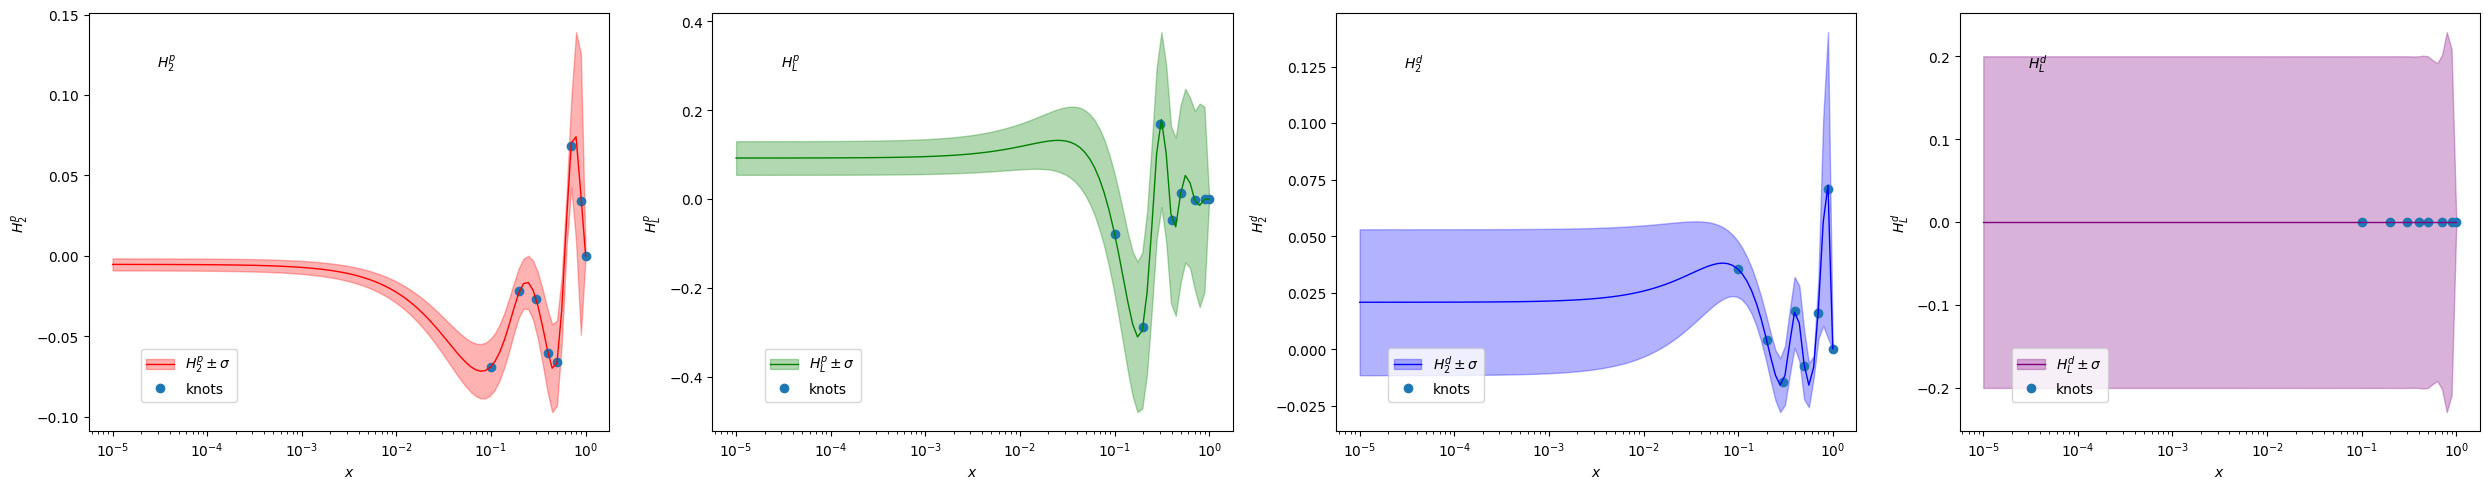

In [27]:
proton_H2 = PlotHT(posteriors.xs("H2p", level='HT').to_numpy().reshape((-1)),
                   np.sqrt(P_tilde.xs("H2p", level='HT').T.xs("H2p", level='HT').to_numpy().diagonal()),
                   x_nodes, 'red', "2", 'p')
proton_HL = PlotHT(posteriors.xs("HLp", level='HT').to_numpy().reshape((-1)),
                   np.sqrt(P_tilde.xs("HLp", level='HT').T.xs("HLp", level='HT').to_numpy().diagonal()),
                   x_nodes, 'green', "L", 'p')
deuteron_H2 = PlotHT(posteriors.xs("H2d", level='HT').to_numpy().reshape((-1)),
                     np.sqrt(P_tilde.xs("H2d", level='HT').T.xs("H2d", level='HT').to_numpy().diagonal()), 
                     x_nodes, 'blue', "2", 'd')
deuteron_HL = PlotHT(posteriors.xs("HLd", level='HT').to_numpy().reshape((-1)),
                     np.sqrt(P_tilde.xs("HLd", level='HT').T.xs("HLd", level='HT').to_numpy().diagonal()), 
                     x_nodes, 'purple', "L", 'd')

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(25, 5))

_ = proton_H2.plot_wrapper(axs[0])
_ = proton_HL.plot_wrapper(axs[1])
_ = deuteron_H2.plot_wrapper(axs[2])
_ = deuteron_HL.plot_wrapper(axs[3])

fig.tight_layout()
fig.savefig(save_dir + "/ht_plots.png")

## Comparison against ABMP

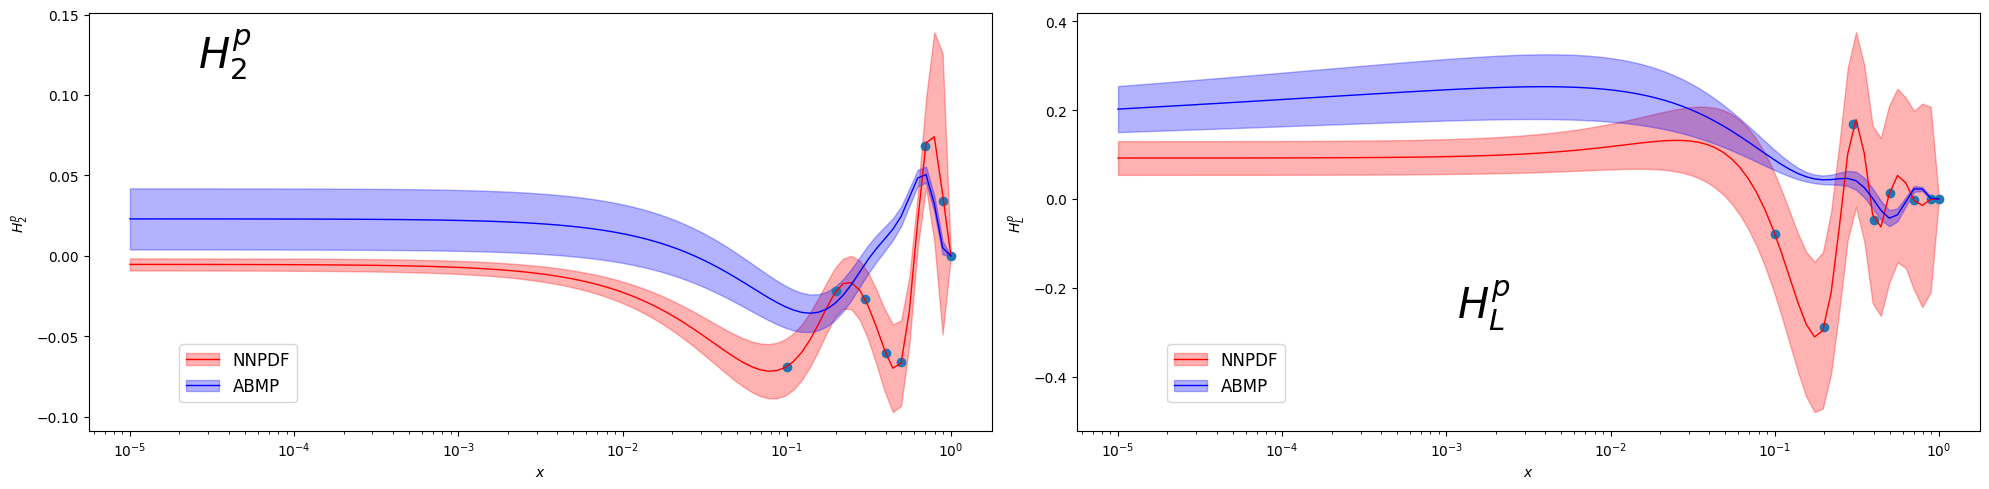

In [28]:
x_abmp = [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1]
y_h2_abmp = [0.023, -0.032, -0.005, 0.025, 0.051, 0.003, 0.0]
y_ht_abmp = [-0.319, -0.134, -0.052, 0.071, 0.030, 0.003, 0.0]
h2_sigma_abmp = [0.019, 0.013, 0.009, 0.006, 0.005, 0.004, 0.0]
ht_sigma_abmp = [0.126, 0.040, 0.030, 0.025, 0.012, 0.007, 0.0]
H_2_abmp = scint.CubicSpline(x_abmp, y_h2_abmp)
H_T_abmp = scint.CubicSpline(x_abmp, y_ht_abmp)

# Reconstruct HL from HT and H2
def H_L(x, h2, ht):
    return (h2 - np.power(x, 0.05) * ht)


H_2_abmp = np.vectorize(H_2_abmp)

H2_plus_abmp = sp.interpolate.CubicSpline(x_abmp, np.add(y_h2_abmp, h2_sigma_abmp))
H2_minus_abmp = sp.interpolate.CubicSpline(x_abmp, np.add(y_h2_abmp, np.multiply(h2_sigma_abmp, -1)))
Ht_plus_abmp = sp.interpolate.CubicSpline(x_abmp, np.add(y_ht_abmp, ht_sigma_abmp))
Ht_minus_abmp = sp.interpolate.CubicSpline(x_abmp, np.add(y_ht_abmp, np.multiply(ht_sigma_abmp, -1)))


fig_abmp, axs_abmp = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
xv = np.logspace(-5, -0.0001, 100)

legends = []
legend_names = ['NNPDF', 'ABMP']

# NNPDF determination
pl_nnpdf= proton_H2.plot_wrapper(axs_abmp[0])
pl = proton_HL.plot_wrapper(axs_abmp[1])
pl[0][0].set_color('red')
pl[2].set_color('red')
legends.append((pl_nnpdf[0][0], pl_nnpdf[1][0]))

# ABMP determination
# H2
pl_abmp = axs_abmp[0].plot(xv, H_2_abmp(xv), ls = "-", lw = 1, color = 'blue')
pl_lg_abmp = axs_abmp[1].fill(np.NaN, np.NaN, color = 'blue', alpha = 0.3) # Necessary for fancy legend
axs_abmp[0].fill_between(xv, H2_plus_abmp(xv), H2_minus_abmp(xv), color = 'blue', alpha = 0.3)
legends.append((pl_abmp[0], pl_lg_abmp[0]))
# HL
HL_abmp = H_L(xv, H_2_abmp(xv), H_T_abmp(xv))
axs_abmp[1].plot(xv, HL_abmp, ls = "-", lw = 1, color = 'blue')
axs_abmp[1].fill(np.NaN, np.NaN, color = 'blue', alpha = 0.3) # Necessary for fancy legend
axs_abmp[1].fill_between(xv, 
                         np.add(H2_plus_abmp(xv), -np.power(xv, 0.05) * Ht_plus_abmp(xv)), 
                         np.add(H2_minus_abmp(xv), -np.power(xv, 0.05) * Ht_minus_abmp(xv)),
                         color = 'blue', alpha = 0.3)

axs_abmp[0].legend(legends, legend_names, loc=[0.1,0.07], fontsize=12)
axs_abmp[1].legend(legends, legend_names, loc=[0.1,0.07], fontsize=12)

axs_abmp[0].set_title(rf"$H^p_2$", x = 0.15, y=0.85, fontsize=30)
axs_abmp[1].set_title(rf"$H^p_L$", x = 0.45, y=0.25, fontsize=30)

fig_abmp.tight_layout()
fig_abmp.savefig(save_dir + "/vs_abmp.png")

## Heatmap for $\tilde{P}$

/opt/homebrew/Caskroom/miniconda/base/envs/nnpdf_doc/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/nnpdf_doc/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


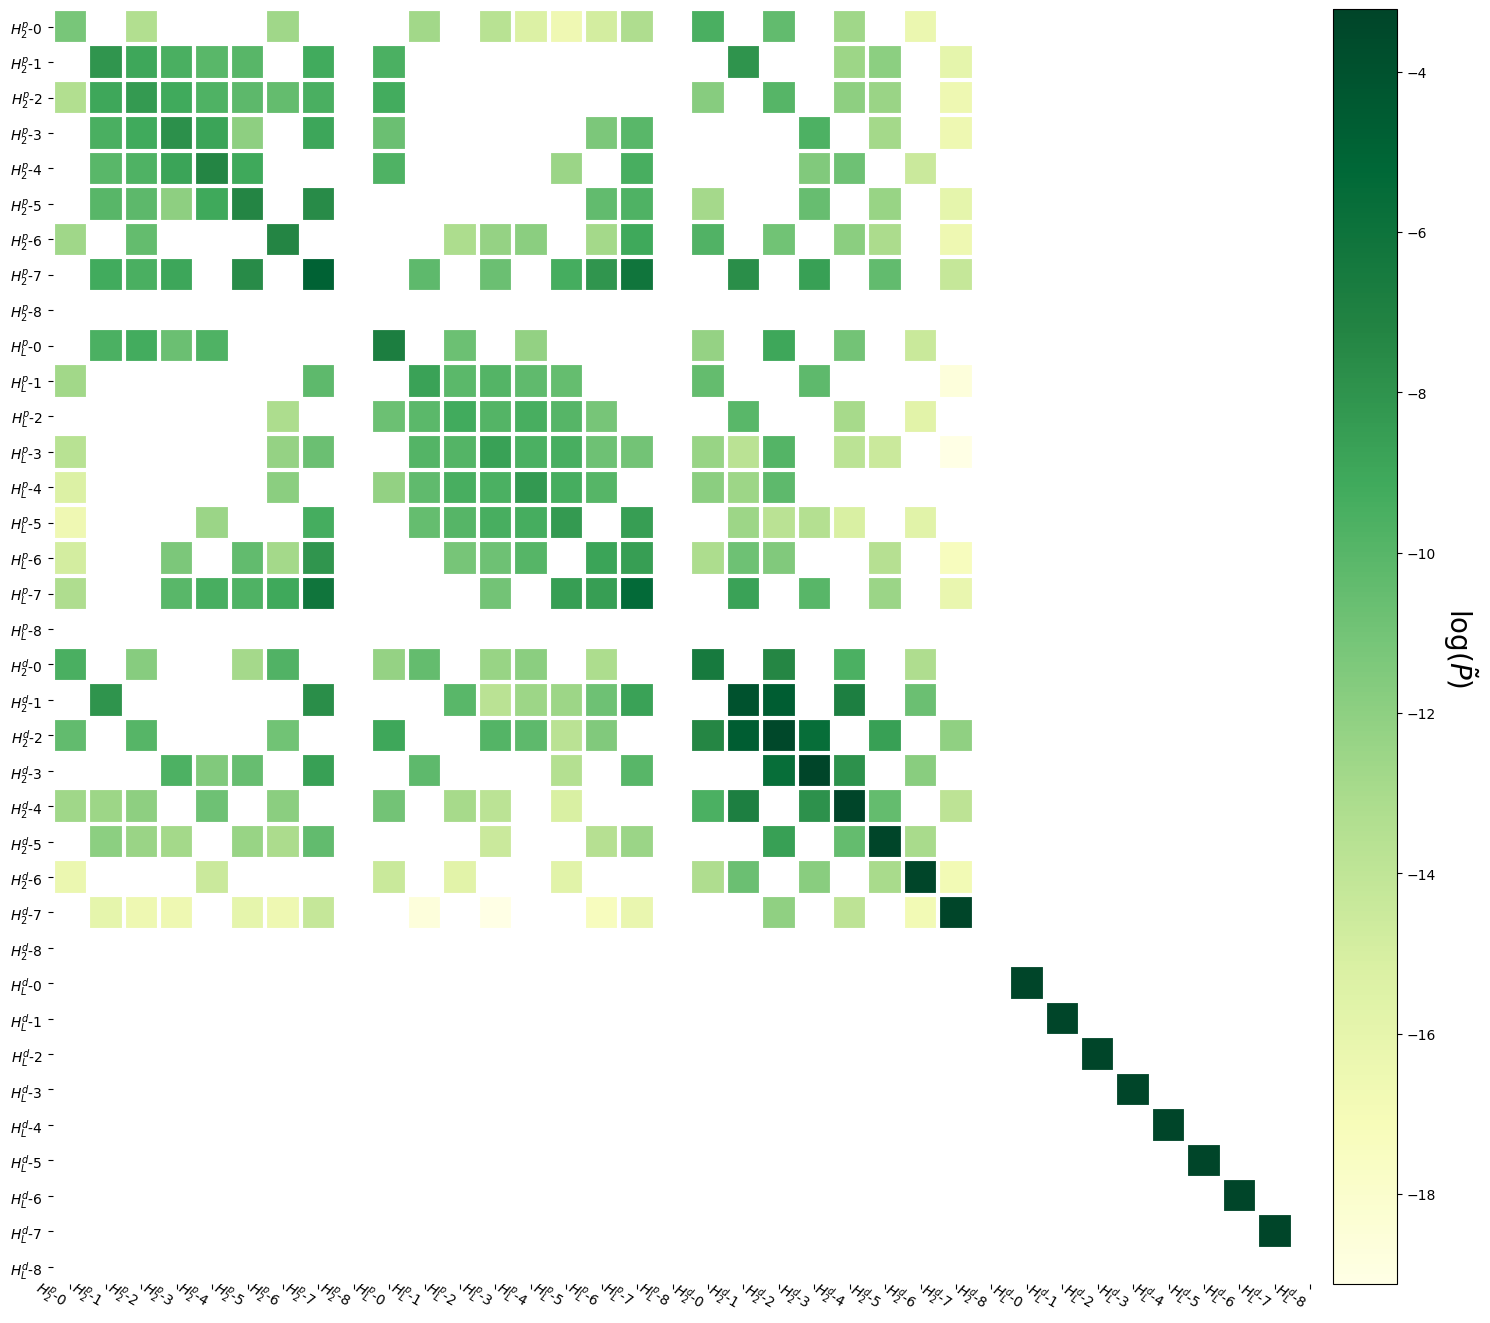

In [29]:
fig_hm, ax_hm = plt.subplots(figsize=(15,15))

# Plot covariance matrix
labels_hm = [
    *[fr"$H_2^p$-{i}" for i in range(len(H2_coeff_list))],
    *[fr"$H_L^p$-{i}" for i in range(len(H2_coeff_list))],
    *[fr"$H_2^d$-{i}" for i in range(len(H2_coeff_list))],
    *[fr"$H_L^d$-{i}" for i in range(len(H2_coeff_list))],
]

im, cbar = heatmap(np.log(P_tilde), labels_hm, labels_hm, ax=ax_hm,
                   cmap="YlGn", cbarlabel=r"$\log(\tilde{P})$")

fig_hm.tight_layout()
fig_hm.savefig(save_dir + '/heatmap.png')

## Table of coefficients

In [30]:
class Prediction:
  def __init__(self, central, sigma):
    self.central = central
    self.sigma = sigma
    self.central_plus_sigma = central + sigma
    self.central_minus_sigma = central - sigma

  def __str__(self) -> str:
    return f"{self.central:.5f} ± {self.sigma:.3f}"

def map_target(i, list_length):
  if i < list_length/2:
    return "proton"
  else:
    return "deutron"
  
def map_type(i, list_length):
  if i%list_length/4 < list_length/4:
    return "H2"
  else:
    return "HL"


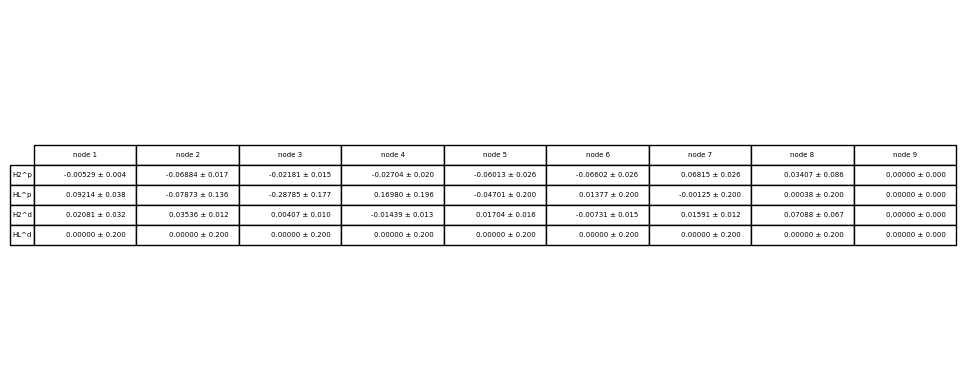

In [31]:
preds_dict = defaultdict(list)
preds_dict['proton'] = {"H2": [Prediction(central, sigma) 
                               for central, sigma in zip(posteriors.xs("H2p", level="HT").to_numpy().reshape((-1)), 
                                                         np.sqrt(P_tilde.xs("H2p", level="HT").T.xs("H2p", level="HT").to_numpy().diagonal())
                                                         )], 
                        "HL": [Prediction(central, sigma) for central, sigma in zip(posteriors.xs("HLp", level="HT").to_numpy().reshape((-1)), 
                                                      np.sqrt(P_tilde.xs("HLp", level="HT").T.xs("HLp", level="HT").to_numpy().diagonal()))]}
preds_dict['deuteron'] = {"H2": [Prediction(central, sigma) for central, sigma in zip(posteriors.xs("H2d", level="HT").to_numpy().reshape((-1)), 
                                                      np.sqrt(P_tilde.xs("H2d", level="HT").T.xs("H2d", level="HT").to_numpy().diagonal()))], 
                          "HL": [Prediction(central, sigma) for central, sigma in zip(posteriors.xs("HLd", level="HT").to_numpy().reshape((-1)), 
                                                      np.sqrt(P_tilde.xs("HLd", level="HT").T.xs("HLd", level="HT").to_numpy().diagonal()))]}

df = pd.DataFrame(np.zeros((4, len(x_nodes))), columns=[f"node {i+1}" for i in range(len(x_nodes))])
df.index = ["H2^p","HL^p","H2^d","HL^d"]
for i in range(len(x_nodes)):
  array = [
    preds_dict['proton']['H2'][i].__str__(),
    preds_dict['proton']['HL'][i].__str__(),
    preds_dict['deuteron']['H2'][i].__str__(),
    preds_dict['deuteron']['HL'][i].__str__()
  ]
  df[f'node {i+1}'] = array


fig_table, ax_posterior = plt.subplots(figsize=(10, 4))  # Set the figure size
ax_posterior.axis('tight')
ax_posterior.axis('off')  # Turn off the axis

# Create a table plot from the DataFrame
table = ax_posterior.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center')

fig_table.tight_layout()
fig_table.savefig(save_dir + "/table.png")